<a href="https://colab.research.google.com/github/pengyk/COMP551/blob/main/Copy_of_Copy_of_mini_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import math



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cases_df = pd.read_csv("drive/My Drive/COMP551/assignment1/aggregated_cc_by.csv")
trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_weekly_symptoms_dataset.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trends_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [5]:
# Getting all us states
us_states = trends_df.open_covid_region_code.unique()
print(us_states)

['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


In [6]:
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
print(us_cases[:100])

   open_covid_region_code region_name        date  hospitalized_new
0                   US-WY     Wyoming  2020-03-07               0.0
1                   US-WY     Wyoming  2020-03-08               0.0
2                   US-WY     Wyoming  2020-03-09               0.0
3                   US-WY     Wyoming  2020-03-10               0.0
4                   US-WY     Wyoming  2020-03-11               0.0
..                    ...         ...         ...               ...
95                  US-WY     Wyoming  2020-06-10               1.0
96                  US-WY     Wyoming  2020-06-11               0.0
97                  US-WY     Wyoming  2020-06-12               0.0
98                  US-WY     Wyoming  2020-06-13               1.0
99                  US-WY     Wyoming  2020-06-14               0.0

[100 rows x 4 columns]


In [7]:
def clean_data(df):
  (rows, cols) = df.shape
  print(rows, cols)
  row_threshold = int(rows * 0.05)
  col_threshold = int(cols * 0.05)

  df = df.dropna(axis = 0, thresh = row_threshold)
  df = df.dropna(axis = 1, thresh = col_threshold)
  df = df.reset_index(drop = True)
  (rows, cols) = df.shape
  print(rows, cols)
  return df

In [8]:
us_cases.columns

Index(['open_covid_region_code', 'region_name', 'date', 'hospitalized_new'], dtype='object')

In [9]:
def group_data_by_weeks(df):
  df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
  df = df.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code','date'])
  return df

us_cases = group_data_by_weeks(us_cases)

In [10]:
print("Before cleaning:")
print(trends_df.shape)

# trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)

Before cleaning:
(608, 430)
After cleaning:
(608, 430)


In [11]:
trends_df['date'] = pd.to_datetime(trends_df['date'])
complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
# print(us_cases['open_covid_region_code'].unique())
# print(trends_df['open_covid_region_code'].unique())
complete_df.head()
# print(complete_df['open_covid_region_code'].unique())

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-02,NaN,NaN,NaN,NaN,NaN,14.62,NaN,NaN,NaN,NaN,NaN,9.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.46,NaN,NaN,NaN,...,NaN,19.43,NaN,NaN,NaN,NaN,NaN,12.96,NaN,NaN,NaN,NaN,21.76,11.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.29,10.46,NaN,NaN,14.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-09,NaN,NaN,NaN,NaN,NaN,10.60,NaN,NaN,11.61,NaN,NaN,12.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.07,NaN,NaN,7.91,NaN,NaN,NaN,NaN,NaN,13.80,NaN,NaN,NaN,...,NaN,11.11,NaN,NaN,NaN,NaN,NaN,13.97,NaN,NaN,NaN,NaN,46.95,10.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.26,NaN,NaN,NaN,18.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.77,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-16,NaN,NaN,NaN,NaN,NaN,11.69,NaN,NaN,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.59,NaN,NaN,7.95,NaN,NaN,NaN,NaN,NaN,11.07,NaN,NaN,NaN,...,NaN,14.49,NaN,NaN,NaN,NaN,NaN,9.04,NaN,NaN,NaN,NaN,78.71,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.53,NaN,NaN,NaN,24.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.34,NaN,NaN,0.0
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-23,NaN,NaN,NaN,NaN,NaN,11.15,16.57,NaN,NaN,NaN,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.39,NaN,NaN,NaN,...,NaN,7.63,NaN,NaN,NaN,NaN,NaN,8.36,NaN,NaN,NaN,NaN,37.54,8.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.75,7.04,NaN,NaN,13.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.69,NaN,NaN,7.0
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-30,NaN,NaN,NaN,NaN,NaN,8.96,8.96,NaN,7.11,NaN,NaN,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.94,NaN,NaN,NaN,...,NaN,9.38,NaN,NaN,NaN,NaN,NaN,14.79,NaN,NaN,NaN,NaN,24.46,9.81,NaN,NaN,7.96,NaN,NaN,NaN,NaN,NaN,7.54,7.11,NaN,NaN,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.63,NaN,NaN,16.0


# Function to pick top 4

In [12]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
tdf = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

print(tdf)
print(tdf['open_covid_region_code'].unique())
complete_df.head()

   open_covid_region_code  ...                            4th Max
0                   US-AK  ...                   symptom:Asphyxia
1                   US-DC  ...                     symptom:Ptosis
2                   US-DE  ...                  symptom:Hypomania
3                   US-HI  ...                 symptom:Laryngitis
4                   US-ID  ...               symptom:Osteoporosis
5                   US-ME  ...                  symptom:Hemolysis
6                   US-MT  ...                     symptom:Chorea
7                   US-ND  ...                   symptom:Asphyxia
8                   US-NE  ...               symptom:Osteoporosis
9                   US-NH  ...          symptom:Shallow breathing
10                  US-NM  ...               symptom:Osteoporosis
11                  US-RI  ...  symptom:Clouding of consciousness
12                  US-SD  ...                    symptom:Anosmia
13                  US-VT  ...                   symptom:Dystonia
14        

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-02,NaN,NaN,NaN,NaN,NaN,14.62,NaN,NaN,NaN,NaN,NaN,9.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.46,NaN,NaN,NaN,...,NaN,19.43,NaN,NaN,NaN,NaN,NaN,12.96,NaN,NaN,NaN,NaN,21.76,11.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.29,10.46,NaN,NaN,14.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-09,NaN,NaN,NaN,NaN,NaN,10.60,NaN,NaN,11.61,NaN,NaN,12.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.07,NaN,NaN,7.91,NaN,NaN,NaN,NaN,NaN,13.80,NaN,NaN,NaN,...,NaN,11.11,NaN,NaN,NaN,NaN,NaN,13.97,NaN,NaN,NaN,NaN,46.95,10.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.26,NaN,NaN,NaN,18.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.77,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-16,NaN,NaN,NaN,NaN,NaN,11.69,NaN,NaN,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.59,NaN,NaN,7.95,NaN,NaN,NaN,NaN,NaN,11.07,NaN,NaN,NaN,...,NaN,14.49,NaN,NaN,NaN,NaN,NaN,9.04,NaN,NaN,NaN,NaN,78.71,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.53,NaN,NaN,NaN,24.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.34,NaN,NaN,0.0
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-23,NaN,NaN,NaN,NaN,NaN,11.15,16.57,NaN,NaN,NaN,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.39,NaN,NaN,NaN,...,NaN,7.63,NaN,NaN,NaN,NaN,NaN,8.36,NaN,NaN,NaN,NaN,37.54,8.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.75,7.04,NaN,NaN,13.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.69,NaN,NaN,7.0
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-30,NaN,NaN,NaN,NaN,NaN,8.96,8.96,NaN,7.11,NaN,NaN,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.94,NaN,NaN,NaN,...,NaN,9.38,NaN,NaN,NaN,NaN,NaN,14.79,NaN,NaN,NaN,NaN,24.46,9.81,NaN,NaN,7.96,NaN,NaN,NaN,NaN,NaN,7.54,7.11,NaN,NaN,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.63,NaN,NaN,16.0


# function to plot

In [13]:
def plot_data(symptoms_df, complete_df):
  symptoms_df = tdf

  # def plot_data(symptoms_df, complete_df):
  # for loop to 
  for index, row in symptoms_df.iterrows():
    # print(row)
    # get region
    region = symptoms_df.open_covid_region_code[index]
    # get the dataframe with this region
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    # print(region_df)
    # get the number of date / number of bins in the histogram
    n_bins = len(region_df)
    # the 4 colours for our 4 most searched symptoms
    # colors = ['red', 'green', 'blue', 'tan']
    # our data in (number of dates, number of symptoms)
    X = np.zeros([4, n_bins])
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      symptom = row.iloc[i + 1]
      # break
      j = 0
      for j, region_row in region_df.iterrows():
        # print(region_row[symptom])
        # print(i)
        # print(j)
        X[i, j] = region_row[symptom]
      plt.plot(X[i])
    print(X)    
    plt.show()
    # break






In [14]:
def knn_classifier(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  # splitted = None
  # if going by region
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,40):
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean(abs(pred_i - Y_test)))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title('By Region')
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)


[array(['US-AK', 'US-DC', 'US-DE', 'US-HI'], dtype=object), array(['US-ID', 'US-ME', 'US-MT'], dtype=object), array(['US-ND', 'US-NE', 'US-NH'], dtype=object), array(['US-NM', 'US-RI', 'US-SD'], dtype=object), array(['US-VT', 'US-WV', 'US-WY'], dtype=object)]
Minimum error:  42.975 at K = 1
Minimum error:  33.50712250712252 at K = 39
Minimum error:  35.044444444444444 at K = 1
Minimum error:  56.40934065934066 at K = 4
Minimum error:  17.6 at K = 1


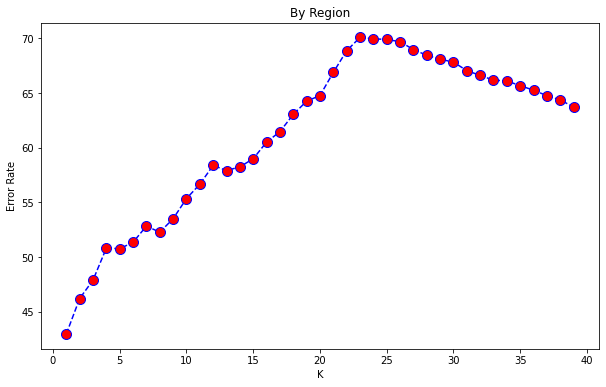

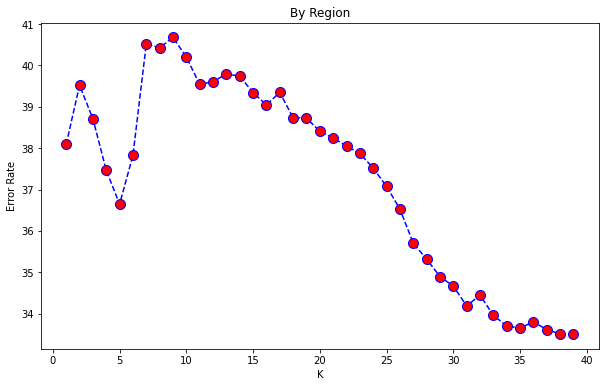

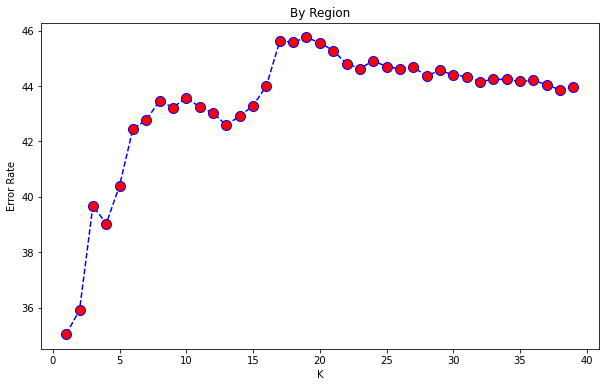

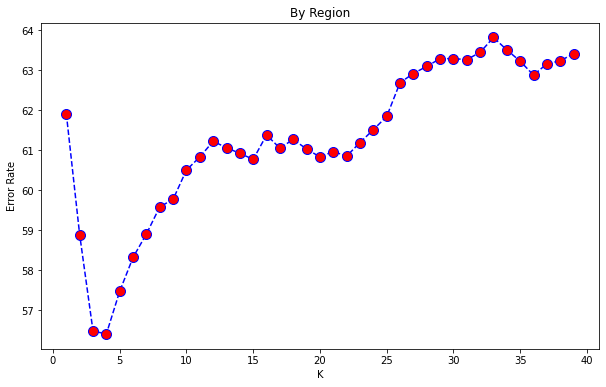

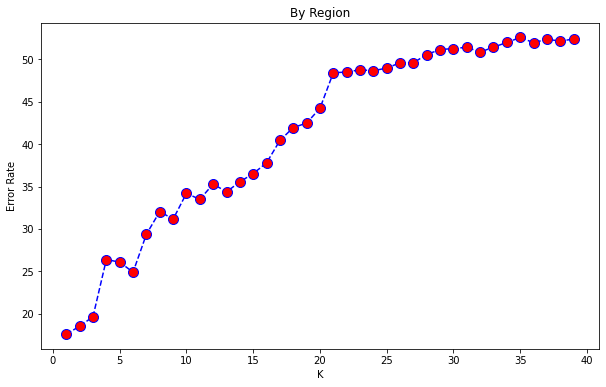

In [15]:
knn_classifier(complete_df, 'region')

[array(['2020-03-02T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
       '2020-04-13T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2020-04-20T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-11T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-25T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-06-01T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000', '2020-06-22T00:00:00.000000000',
       '2020-06-29T00:00:00.000000000', '2020-07-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-13T00:00:00.000000000', '2020-07-20T00:00:00.000000000',
       '2020-07-27T00:00:00.000000000', '2020-08-03T00:00:00.000000000',
       '2020-08-10T00:00:00.000000000', '2020-08-17T00:00:00.00000

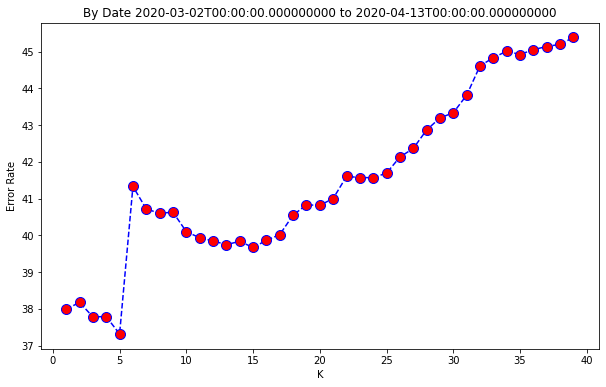

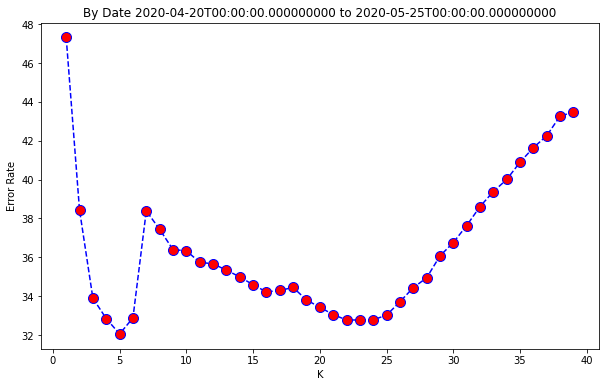

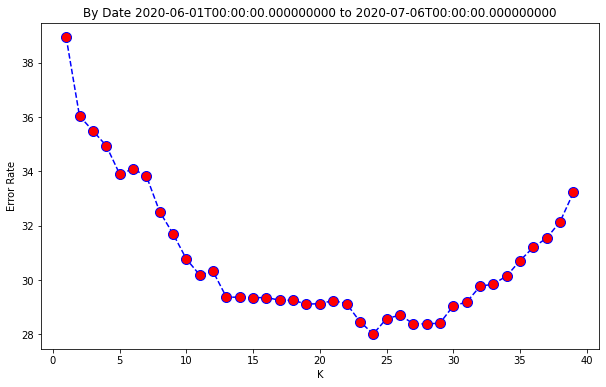

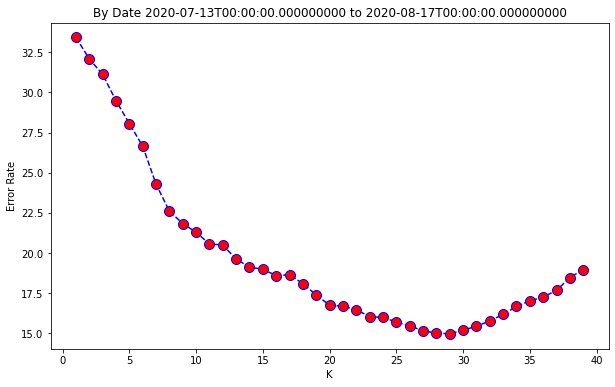

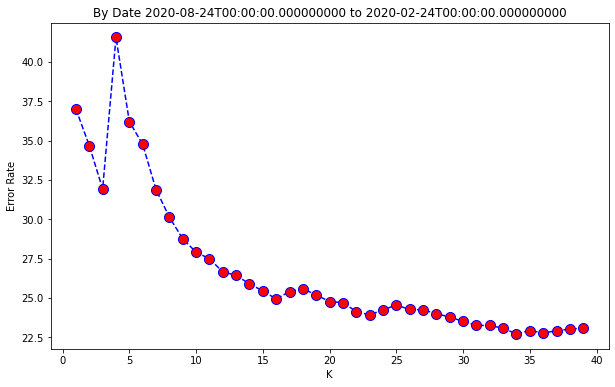

In [16]:
knn_classifier(complete_df, 'time')

In [38]:
def decisionTree_regressor(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  # splitted = None
  # if going by region
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,40):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean(abs(pred_i - Y_test)))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title(','.join(test_list))
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate))+1)

[array(['US-AK', 'US-DC', 'US-DE', 'US-HI'], dtype=object), array(['US-ID', 'US-ME', 'US-MT'], dtype=object), array(['US-ND', 'US-NE', 'US-NH'], dtype=object), array(['US-NM', 'US-RI', 'US-SD'], dtype=object), array(['US-VT', 'US-WV', 'US-WY'], dtype=object)]
['US-AK' 'US-DC' 'US-DE' 'US-HI']
['US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE' 'US-NH' 'US-NM' 'US-RI' 'US-SD'
 'US-VT' 'US-WV' 'US-WY']
Minimum error:  31.014594396456104 at depth level = 2
['US-ID' 'US-ME' 'US-MT']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ND' 'US-NE' 'US-NH' 'US-NM' 'US-RI'
 'US-SD' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  26.69694041867955 at depth level = 1
['US-ND' 'US-NE' 'US-NH']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-NM' 'US-RI'
 'US-SD' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  36.682678062678086 at depth level = 2
['US-NM' 'US-RI' 'US-SD']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  62.47252415759193 at depth leve

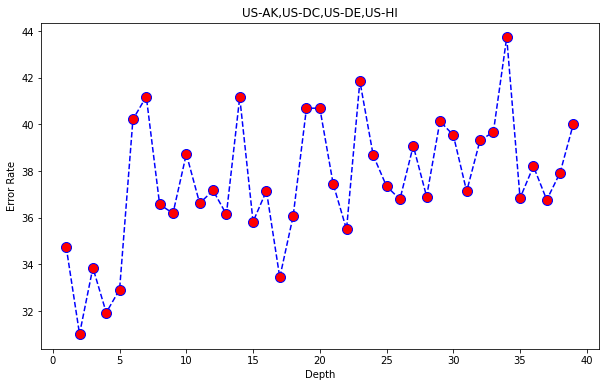

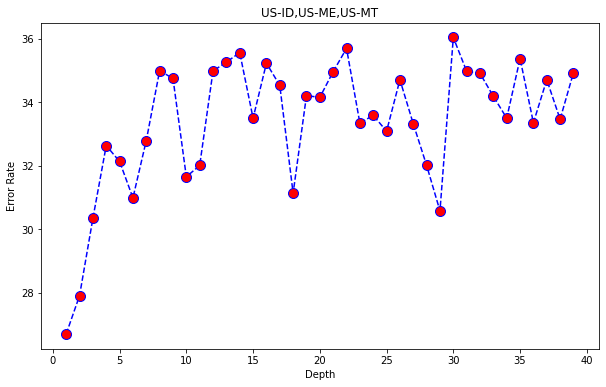

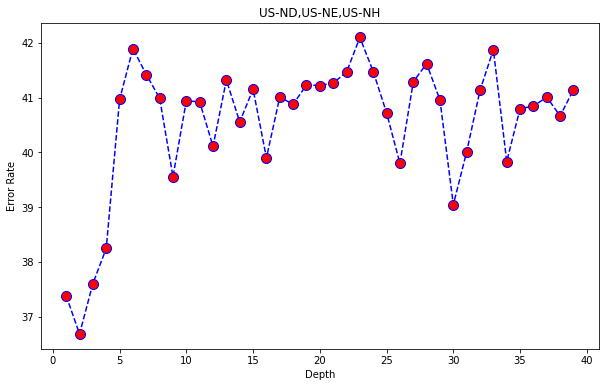

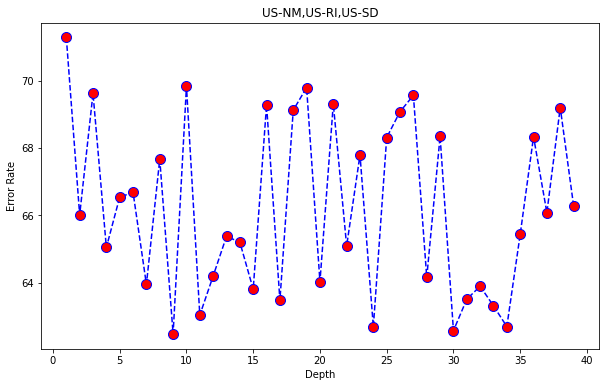

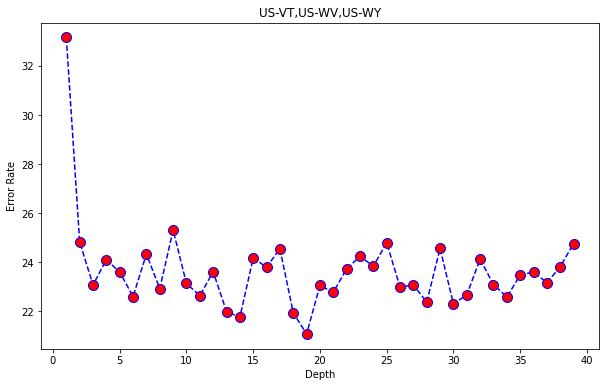

In [39]:
decisionTree_regressor(complete_df, 'region')